In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2023-08-30 14:49:55.518249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 14:49:56.327199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
df = pd.read_csv("https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip")
print(df.shape)
df.info()

(420551, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [7]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
print(f"train_split: {train_split}")
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

train_split: 300693


In [24]:
selected_features = [df.columns[i+1] for i in [0, 1, 5, 7, 8, 10, 11]]
print(f"selected features: {selected_features}")

features = df[selected_features]
features.index = df["Date Time"]
print(features.shape)
features.head(3)

selected features: ['p (mbar)', 'T (degC)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)']
(420551, 7)


,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19


In [25]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].mean(axis=0)

    return (data-data_mean) / data_std

features = pd.DataFrame(normalize(features.values, train_split))
print(features.shape)
features.head(3)

(420551, 7)


,0,1,2,3,4,5,6
0,0.007952,-1.867008,-0.752665,-0.945107,-0.675372,0.075157,-0.520780
1,0.008002,-1.909169,-0.760093,-0.947602,-0.683739,0.076843,-0.665011
2,0.007962,-1.919980,-0.761578,-0.950097,-0.685412,0.077204,-0.911600


In [26]:
train_data = features.loc[0:train_split-1]
val_data = features.loc[train_split:]
print(train_data.shape, val_data.shape)

(300693, 7) (119858, 7)


In [32]:
start = past + future
end = start + train_split

x_train = train_data.values
y_train = features.iloc[start:end][[1]]

print(x_train.shape, y_train.shape)

sequence_length = int(past / step)
print(f"sequence_length: {sequence_length}")

(300693, 7) (300693, 1)
sequence_length: 120


In [37]:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate = step,
    batch_size=batch_size
)

In [40]:
x_end = len(val_data) - past - future
label_start = train_split + past + future
print(f"x_end, label_start: {x_end, label_start}")

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

x_end, label_start: (119066, 301485)
Input shape: (256, 120, 7)
Target shape: (256, 1)


2023-08-30 15:57:54.651998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [300693,1]
	 [[{{node Placeholder/_20}}]]
2023-08-30 15:57:54.652309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [299974]
	 [[{{node Placeholder/_8}}]]


In [43]:
inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = tf.keras.layers.LSTM(32)(inputs)
outputs = tf.keras.layers.Dense(1)(lstm_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="mse"
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                5120      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


2023-08-30 16:03:28.968133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-30 16:03:28.969457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-30 16:03:28.970281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [46]:
path_checkpoint = "model.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10


2023-08-30 16:04:04.279396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [300693,1]
	 [[{{node Placeholder/_20}}]]
2023-08-30 16:04:04.279836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [299974]
	 [[{{node Placeholder/_28}}]]
2023-08-30 16:04:04.469553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/sp

1171/1172 [============================>.] - ETA: 0s - loss: 0.1529

2023-08-30 16:04:46.286504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [118347]
	 [[{{node Placeholder/_8}}]]
2023-08-30 16:04:46.286831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [119066,7]
	 [[{{node Placeholder/_0}}]]
2023-08-30 16:04:46.465227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_


Epoch 1: val_loss improved from inf to 0.12725, saving model to model.h5
1172/1172 [==============================] - 51s 43ms/step - loss: 0.1528 - val_loss: 0.1273
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1054
Epoch 2: val_loss did not improve from 0.12725
1172/1172 [==============================] - 62s 53ms/step - loss: 0.1054 - val_loss: 0.1324
Epoch 3/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.0998
Epoch 3: val_loss did not improve from 0.12725
1172/1172 [==============================] - 50s 43ms/step - loss: 0.0998 - val_loss: 0.1322
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.0974
Epoch 4: val_loss did not improve from 0.12725
1172/1172 [==============================] - 50s 43ms/step - loss: 0.0974 - val_loss: 0.1309
Epoch 5/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.0954
Epoch 5: val_loss did not improve from 0.12725
1172/1172 [==============================] - 51s 4

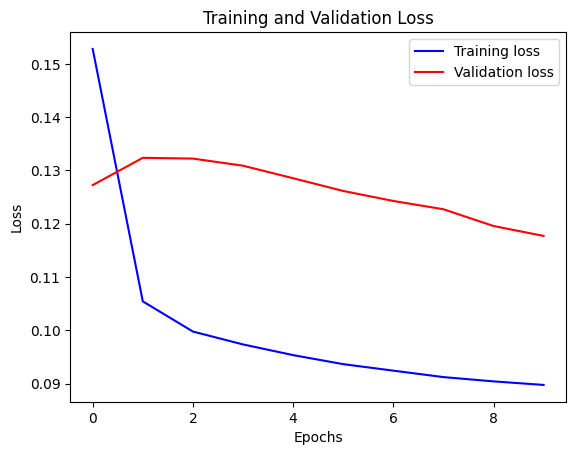

In [47]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")